In [1]:
import time
import brainstate
import braintools
import brainunit as u
import matplotlib.pyplot as plt
import braincell

class ThalamusNeuron(braincell.neuron.SingleCompartment):
    def compute_derivative(self, x=0. * u.nA):
        return super().compute_derivative(x * self.area)

    def step_run(self, t, inp):
        with brainstate.environ.context(t=t):
            self.update(inp)
            return self.V.value

In [2]:
class Test_Neuron(braincell.neuron.SingleCompartment):
    def compute_derivative(self, x=0. * u.nA):
        return super().compute_derivative(x * self.area)

    def step_run(self, t, inp):
        with brainstate.environ.context(t=t):
            self.update(inp)
            return self.V.value

In [3]:
class HH(Test_Neuron):
    def __init__(
        self,
        size,
        gKL=0.01 * (u.mS / u.cm ** 2),
        V_initializer=brainstate.init.Constant(-65. * u.mV),
        solver: str = 'exp_euler'
    ):
        super().__init__(size, V_initializer=V_initializer, V_th=20. * u.mV, solver=solver)

        self.area = 1e-3 / (2.9e-4 * u.cm ** 2)

        self.na = braincell.ion.SodiumFixed(self.varshape, E=50. * u.mV)
        self.na.add(INa =braincell.channel.INa_Rsg(self.varshape, g_max= 15 * u.mS / (u.cm ** 2)))
        #self.na = braincell.ion.SodiumFixed(size, E=50. * u.mV)
        #self.na.add(INa=braincell.channel.INa_Ba2002(size, V_sh=-30 * u.mV))

        #self.k = braincell.ion.PotassiumFixed(size, E=-90. * u.mV)
        #self.k.add(IKL=braincell.channel.IK_Leak(size, g_max=gKL))

        self.IL = braincell.channel.IL(size, g_max=0.0075 * (u.mS / u.cm ** 2), E=-70 * u.mV)


Elapsed time: 1171.9341 s


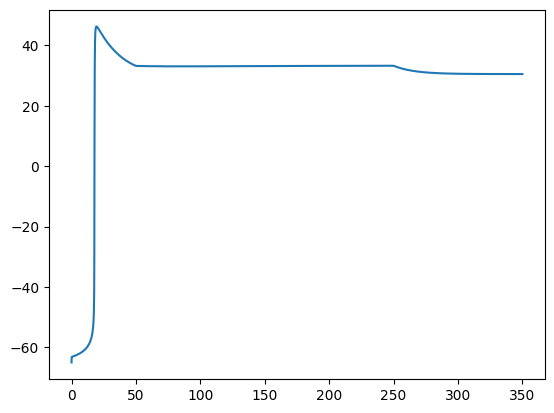

In [7]:
def try_trn_neuron():
    import jax
    #jax.config.update("jax_disable_jit", True)
    brainstate.environ.set(dt=0.002 * u.ms)

    I = braintools.input.section_input(values=[0, 0.05, 0], durations=[50 * u.ms, 200 * u.ms, 100 * u.ms]) * u.uA
    times = u.math.arange(I.shape[0]) * brainstate.environ.get_dt()

    # neu = HTC(1)  # [n_neuron, ]
    # neu = IN(1)  # [n_neuron, ]
    # neu = RTC(1)  # [n_neuron, ]
    neu = HH(1, solver='splitting')  # [n_neuron,]
    neu.init_state()

    t0 = time.time()
    vs = brainstate.compile.for_loop(neu.step_run, times, I)
    t1 = time.time()
    print(f"Elapsed time: {t1 - t0:.4f} s")

    plt.plot(times.to_decimal(u.ms), u.math.squeeze(vs.to_decimal(u.mV)))
    plt.show()


if __name__ == '__main__':
    try_trn_neuron()